In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import sys

#and print TensorFlow Version
print(tf.__version__)

2.2.0


In [2]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('acc')>=0.99):
            print("\nReached 99% accuracy ")
            self.model.stop_training = True

callbacks = myCallback()

In [3]:
# Define dirs and files
train_dir = '../data/training/'
validation_dir = '../data/validation/'

train_wash_dir = os.path.join(train_dir,'wash')
train_nowash_dir = os.path.join(train_dir,'nowash')
validation_wash_dir = os.path.join(validation_dir,'wash')
validation_nowash_dir = os.path.join(validation_dir,'nowash')

train_wash_fnames = os.listdir(train_wash_dir)
train_nowash_fnames = os.listdir(train_nowash_dir)
validation_wash_fnames = os.listdir(validation_wash_dir)
validation_nowash_fnames = os.listdir(validation_nowash_dir)


print(len(os.listdir(train_wash_dir)))
print(len(os.listdir(train_nowash_dir)))
print(len(os.listdir(validation_wash_dir)))
print(len(os.listdir(validation_nowash_dir)))

total_train=len(os.listdir(train_wash_dir))+ len(os.listdir(train_nowash_dir))
total_val=len(os.listdir(validation_wash_dir))+ len(os.listdir(validation_nowash_dir))

115
186
16
23


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# rescale val data
val_datagen = ImageDataGenerator(rescale = 1./255.)

#set batch Size
batch_size = 10

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = (300,300))

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                         batch_size = batch_size,
                                                         class_mode = 'binary',
                                                         target_size = (300,300))


Found 301 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [5]:
metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [11]:
#base model, fully trainable but started w/ imagenet weights
base_model = tf.keras.applications.MobileNet(input_shape=(300,300,3), include_top=False, weights='imagenet')

base_model.trainable = True
base_model.summary()


17227776/17225924 [==============================] - 5s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 301, 301, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 150, 150, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 150, 150, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)      288       
_________________________________________________

In [14]:
final_layer = base_model.get_layer('conv_pw_12_relu')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(base_model.input, x) 

model.summary()

shape of last layer is  (None, 9, 9, 1024)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 301, 301, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 150, 150, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 150, 150, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)      288       
_________________________________________________________________
conv_dw_1_bn (Ba

In [17]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=All_The_Metrics)

In [21]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = total_train // batch_size,
                              validation_data = validation_generator,
                              epochs= 10,
                              validation_steps =  total_val // batch_size,
                              callbacks =[callbacks])

Epoch 1/10
30/30 [==============================] - 60s 2s/step - loss: 1.2895 - tp: 88.0000 - fp: 25.0000 - tn: 154.0000 - fn: 24.0000 - acc: 0.8316 - precision: 0.7788 - recall: 0.7857 - auc: 0.8747 - val_loss: 2.0320 - val_tp: 11.0000 - val_fp: 4.0000 - val_tn: 11.0000 - val_fn: 4.0000 - val_acc: 0.7333 - val_precision: 0.7333 - val_recall: 0.7333 - val_auc: 0.8156
Epoch 2/10
30/30 [==============================] - 60s 2s/step - loss: 0.7462 - tp: 90.0000 - fp: 22.0000 - tn: 156.0000 - fn: 23.0000 - acc: 0.8454 - precision: 0.8036 - recall: 0.7965 - auc: 0.9159 - val_loss: 0.4934 - val_tp: 10.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 3.0000 - val_acc: 0.8667 - val_precision: 0.9091 - val_recall: 0.7692 - val_auc: 0.9819
Epoch 3/10
30/30 [==============================] - 61s 2s/step - loss: 0.8476 - tp: 83.0000 - fp: 25.0000 - tn: 160.0000 - fn: 23.0000 - acc: 0.8351 - precision: 0.7685 - recall: 0.7830 - auc: 0.8896 - val_loss: 1.6475 - val_tp: 10.0000 - val_fp: 2.0000 - v

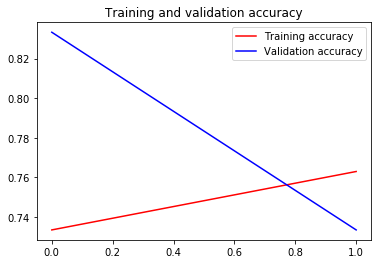

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [16]:
#Confusion matrix


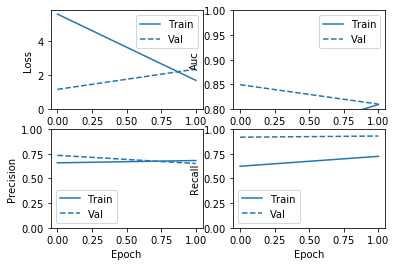

In [20]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)


In [ ]:
#gradCAM or Shap